## 책 제목 기반 추천시스템 recommendation_by_title
 - bookdata.csv에 있는 title, review을 활용하여 title을 입력하면 그 title과 리뷰가 유사한 책을 추천
 - 작동 설명
     1. review에 있는 데이터들로 임베딩 모델을 만든 뒤 책마다 특정 벡터값을 가질 수 있도록 토큰화된 단어들의 벡터값의 평균을 낸다.
     2. 책 제목을 인자로 입력받으면 해당 책과 문서 벡터값이 가장 유사한 5명의 책을 추천한다.

1. 데이터 로드

In [1]:
# 패키지 임포트
!pip install numpy==1.20.0
!pip install gensim==3.7.0 --user
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from konlpy.tag import Okt
from io import BytesIO
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# 데이터를 데이터프레임으로 로드하고, 전체 문서의 수 출력

In [3]:
import io

df = pd.read_csv('bookdata.csv')
print('전체 문서의 수 : ', len(df))

전체 문서의 수 :  139


In [4]:
# 상위 5행만 출력하여 확인

In [5]:
df[:5]

,title,author,isbn13,review
0,달러구트 꿈 백화점 2,이미예,9791165343729,달러구트 꿈백화점 1권을 읽으신 분들이라면 2권을 손꼽아 기다렸을 것이다. 나 또한...
1,달러구트 꿈 백화점,이미예,9791165341909,평소에 책을 너무 안 읽는 것 같아 계속 베스트셀러에 올라와 있기에 주문해 보았습니...
2,미드나잇 라이브러리,매트 헤이그,9791191056556,죽음이라는 주제로 어둡게 이야기가 흘러가지는 않을까 걱정했는데 죽음보다는 인생에 대...
3,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",이치조 미사키,9791191043297,우연히 SNS에서 이 책의 줄거리를 읽게 되었습니다. 이런 표지의 감성을 담은 소설...
4,완전한 행복,정유정,9791167370280,무서워서 낮에만 읽으려고 했던 나의 결심?다짐?을 반달늪에 쳐박아 버린 소설. 정유...


In [6]:
# 형태소 분석 하기 전 사용자 사전 추가
from ckonlpy.tag import Twitter

twitter = Twitter()
twitter.add_dictionary(list(df['author']), 'Noun')

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [7]:
# 'Desc' 열을 대상으로 전처리를 수행하여 'cleaned'에 저장

In [8]:
def _removeNonAscii(text):
    letters_only = re.sub('[^ 0-9가-힣]', '', text)   
    return letters_only

def remove_stop_words(text):    
    
    twitter = Twitter()
    tokenized_data = []
    #temp_X = twitter.nouns(text) # 토큰화
    temp_X = twitter.morphs(text, stem=True) # 토큰화
    
    # 5. Stopwords 불용어 제거    
    file=open('bool.txt','r',encoding='UTF8')
    stopwords=file.readlines()[0].split(' ')
    file.close()
    
    temp_X = [word for word in temp_X if not word in stopwords] 
    tokenized_data.append(temp_X)
    return( ' '.join(temp_X) )

df['cleaned'] = df['review'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)

In [9]:
# 상위 5행만 출력하여 확인

In [10]:
df['cleaned'][:5]

0    달러 구트 꿈 백화점 1 권 읽다 분 라면 2 권 손꼽다 기다리다 2 권 에서는 어...
1    평소 책 너무 읽다 계속 베스트셀러 올라오다 주문 해 판타지 내용 그냥 가볍다 읽다...
2    죽음 이라는 주제 어둡다 이야기 흐르다 걱정 죽음 보다는 인생 깊다 다 루고 좋다 ...
3    우연 히 책 줄거리 읽다 되어다 이렇다 표지 감성 담다 소설 취향 자다 읽다 줄거리...
4    무섭다 낮 에만 읽다 결심 다짐 반달 늪 치다 박아 버리다 소설 정유 정 작가 소설...
Name: cleaned, dtype: object

In [13]:
# 빈 값이 있는 행 확인, nan 값으로 변환 후 해당 행 제거

In [14]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :', len(df))

전체 문서의 수 : 139


In [15]:
# 토큰화하여 corpus 라는 리스트에 저장

In [16]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

2. Word2Vec을 통해 이를 초기 단어 벡터값으로 워드 임베딩

In [17]:
model = Word2Vec(corpus, size = 300, window=5, min_count = 10, workers = -1)

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


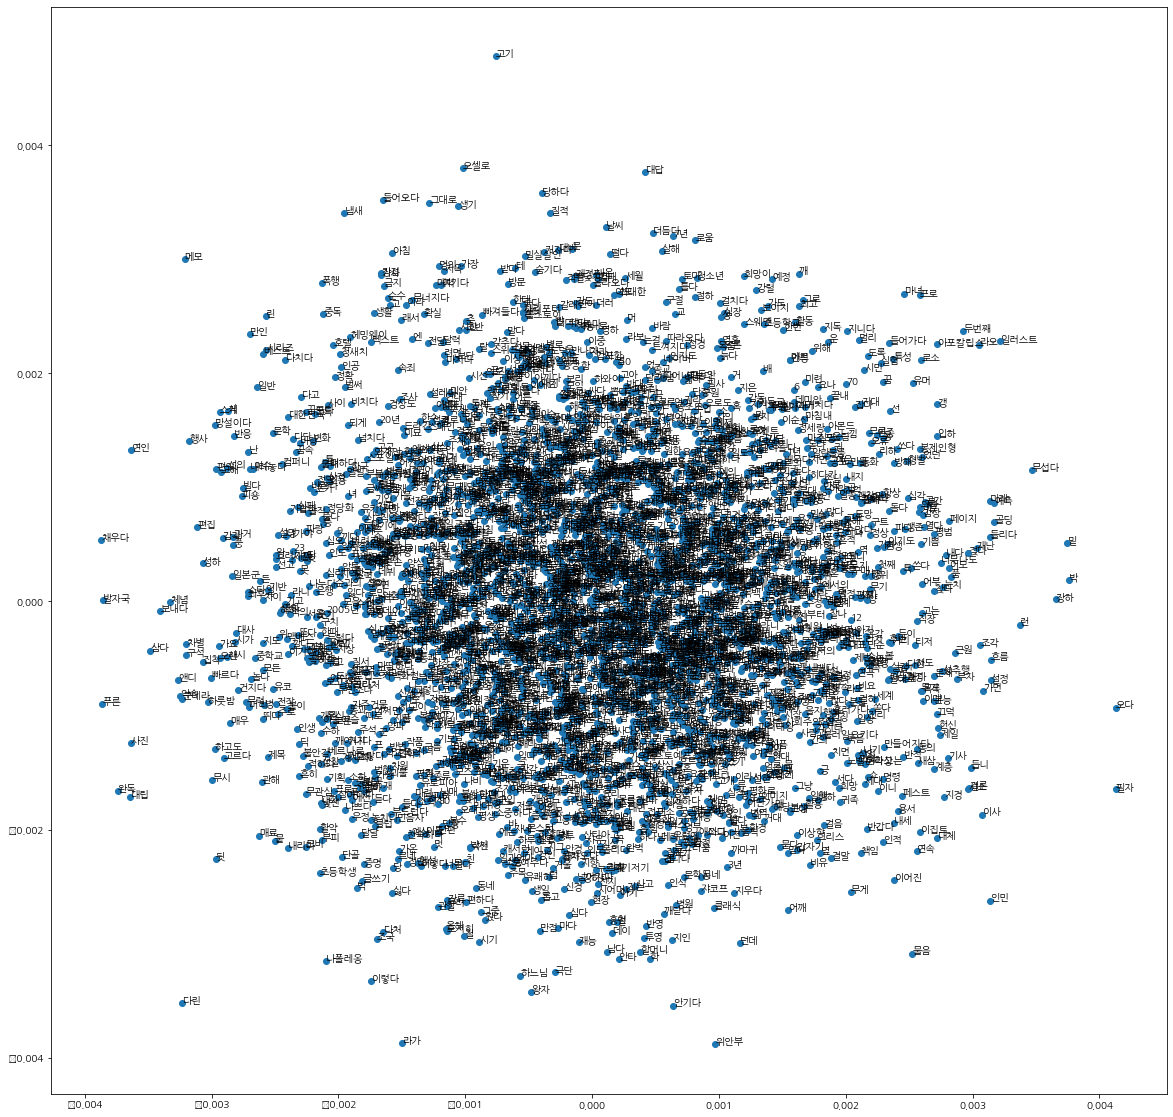

In [18]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
fm._rebuild()

plt.rc('font', family='NanumGothic')

import matplotlib.pyplot as plt

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

3. 단어 벡터의 평균 구하기

In [19]:
word2vec_model=model
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab.keys():
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list 

In [20]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

<ipython-input-19-ca7270387c53>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
<ipython-input-19-ca7270387c53>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 139


4. 추천 시스템 구현하기

In [21]:
# 각 벡터간 코사인 유사도

cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (139, 139)


In [22]:
# 코사인 유사도를 이용하여, 가장 줄거리가 유사한 5개의 책을 찾아내는 함수 만들기

In [23]:
def recommendations_by_title(title):
    books = df[['title']]
    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates() 
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for i in book_indices:
        print(books.loc[i]['title'])

In [24]:
# 확인 : 책 제목을 입력하면 이와 유사한 책들 추천(제목, 표지)

In [28]:
recommendations_by_title('구의 증명')

종의 기원
날씨가 좋으면 찾아가겠어요
회색 인간
한국단편소설 70
2021 제12회 젊은작가상 수상작품집


In [29]:
recommendations_by_title('완전한 행복')

7년의 밤
종의 기원
고백
진이, 지니
한국단편소설 70


In [30]:
recommendations_by_title('파과')

2021 제12회 젊은작가상 수상작품집
회색 인간
고백
불안한 사람들
모순


In [31]:
recommendations_by_title('지구에서 한아뿐')

2021 제12회 젊은작가상 수상작품집
목소리를 드릴게요
구의 증명
날씨가 좋으면 찾아가겠어요
모순


In [36]:
recommendations_by_title('사랑하라 한번도 상처받지 않은 것처럼')

마음챙김의 시
날씨가 좋으면 찾아가겠어요
시를 잊은 그대에게 (리커버 에디션)
천 개의 파랑
그런 사람 또 없습니다
